## Analysis of datasets + stats for compressing with FPDE
This notebook contains methods for passing a .shp-file (or directory) and obtaining stats for the FPDE properties of the compression. Stats include the number of chunks, number of deltas within each chunk, average number of vertices, and a distribution of the overhead within the format.

## Evaluating one shape-file
The methods take one .shp-file and return the stats. Multiple calls can be merged further done if a set of .shp-files are to be analysed.

In [5]:
import jsonlines
import glob
import osmnx as ox
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import folium
import tqdm
import shapely
import random
import os
from shapely.wkt import loads
from algos.fpd_extended_lib.cfg import *
import numpy as np
import re
import seaborn as sns
from algos.alg_fpd_extended import FpdExtended

In [6]:
#df = gpd.read_file('data/ne_10m_admin_1_states_provinces.shp')
#df = gpd.read_file('data/sweden-latest-free/gis_osm_buildings_a_free_1.shp')
#df = gpd.read_file('data/sweden-latest-free/gis_osm_natural_a_free_1.shp')
MAX_ITER = -1

def load_shp(file_name, DO_VERTEX_CNT):
    df = gpd.read_file(file_name)
    print("Count of entries:", len(df))
    df = df[df.type != "Point"]
    print("---", file_name, "---")
    print("Count of entries (no points):", len(df))
    shapes = df.geometry

    vertex_cnt = []
    if DO_VERTEX_CNT:
        for s in tqdm.tqdm(shapes[0:MAX_ITER]):
            vertex_cnt.append(shapely.get_num_coordinates(s))

        vertex_cnt = np.array(vertex_cnt)
        if len(vertex_cnt) != 0:
            res = f"Total: {len(vertex_cnt)}, avg: {round(np.average(vertex_cnt), 2)}, std: {round(np.std(vertex_cnt), 2)}, median: {np.median(vertex_cnt)}, min: {np.min(vertex_cnt)}, max: {np.max(vertex_cnt)}, #>=25: {(vertex_cnt >= 25).sum()} ({round(100 * (vertex_cnt >= 25).sum() / len(vertex_cnt), 2)}), #>=100: {(vertex_cnt >= 100).sum()} ({round(100 * (vertex_cnt >= 100).sum() / len(vertex_cnt), 2)}), #>=200: {(vertex_cnt >= 200).sum()} ({round(100 * (vertex_cnt >= 200).sum() / len(vertex_cnt), 2)}), #>=500: {(vertex_cnt >= 500).sum()} ({round(100 * (vertex_cnt >= 500).sum() / len(vertex_cnt), 2)}), #>=1000: {(vertex_cnt >= 1000).sum()} ({round(100 * (vertex_cnt >= 1000).sum() / len(vertex_cnt), 2)})"
            print(res)
            with open('vertex_cnt_for_datasets.txt', 'a') as f:
                f.write(f"{file_name}\n{res}\n\n")
        else:
            print("No geometries (except Point(s)) in dataset.")
    return shapes, vertex_cnt

In [7]:
from algos.fpd_extended_lib.decompress import decode_header
from algos.fpd_extended_lib import cfg

def fpde_analyze(shapes):
    stats = pd.DataFrame(columns=["No Comp Size", "Comp Size", "Comp Factor", "Delta Size", "Vertex Cnt", "Chunk Cnt", "Avg Vertices in Chk", "Std Vertices in Chk", "Median Vertices in Chk", "Min Vertices in Chk", "Max Vertices in Chk"])
    stats_distribution = pd.DataFrame()
    stats_max_values = pd.DataFrame()
    alg = FpdExtended()

    for idx, s in enumerate(tqdm.tqdm(shapes[0:MAX_ITER])):
        bin = alg.compress(s)[1]
        wkb_len = len(shapely.to_wkb(s))
        bin_len = len(bin)
        coords_len = shapely.get_num_coordinates(s)

        chks, _, overhead_stats = alg.get_chunks(bin, include_ring_start=False, verbose=True)
        cfg.offset = 0
        d_size, geom_type = decode_header(bin)
        chk_cnt = len(chks)
        chk_lens = list(map(lambda x: len(x), chks))

        stats.loc[len(stats)] = [wkb_len, bin_len, wkb_len / bin_len, d_size, coords_len, chk_cnt, np.average(chk_lens), np.std(chk_lens), np.median(chk_lens), np.min(chk_lens), np.max(chk_lens)]

        # Analysis of space
        max_values, distrb = overhead_stats
        theoretical_size = sum(distrb.values())
        distrb = pd.DataFrame(distrb, index=[idx])
        stats_distribution = pd.concat([stats_distribution, distrb])
        stats_max_values = pd.concat([stats_max_values, pd.DataFrame(max_values, index=[idx])])

        DISPLAY_PER_SHAPE_STATS = False
        if DISPLAY_PER_SHAPE_STATS:
            display(distrb)
            print("Size (calculated, rounded to byte, real):", theoretical_size, f"({((theoretical_size + 7) & (-8))})", bin_len * 8)
            print("Max Values:", dict(max_values))

    print("---- AVERAGE COMPRESSED SHAPE ----")
    pd.set_option('display.precision', 2)
    display(stats.mean())
    print("Global: Min Vertices in Chk / Max Vertices in Chk", np.min(stats['Min Vertices in Chk']), np.max(stats['Max Vertices in Chk']))

    print("---- DATA DISTRIBUTION ----")
    final_distribution = stats_distribution.mean()
    display(final_distribution)
    display(final_distribution.apply(lambda x: 100 * x / sum(final_distribution)))

    print("---- TO SET MANUAL PARAMS ----")
    final_max_values = stats_max_values.max()
    min_bits = final_max_values.apply(lambda x: required_bits(x))
    min_bits = min_bits.add_prefix("Bits ")
    res = pd.concat([final_max_values, min_bits])
    display(res)
    return res

In [8]:
DATASET = 'data/sweden-latest-free/gis_osm_railways_free_1.shp'
#DATASET = 'data/sweden-latest-free'
#DATASET = 'data/sweden-latest-free/gis_osm_natural_free_1.shp'
#DATASET = "data/new-york-latest-free"
#DATASET = "data/sweden-latest-free/gis_osm_roads_free_1.shp"
DATASET = 'data/ne_10m_admin_1_states_provinces.shp'
ONLY_VERTEX_CNT = False # Can be used if only the amount of vertices in the dataset is required

if DATASET.endswith(".shp"):
    files = [DATASET]
else:
    files = glob.glob(DATASET + '/*.shp')
#files = ["data/sweden-latest-free/gis_osm_buildings_a_free_1.shp", "data/sweden-latest-free/gis_osm_roads_free_1.shp", "data/china-latest-free/gis_osm_water_a_free_1.shp", "data/ne_10m_admin_1_states_provinces.shp"]
#files = ["data/sweden-latest-free/gis_osm_railways_free_1.shp", "data/ne_10m_admin_1_states_provinces.shp"]

legends = ["Sweden Buildings", "Sweden Roads", "China Water", "Country Borders"]

all_vertex_cnts = []
for f in tqdm.tqdm(files):
    shapes, vertex_cnt = load_shp(f, ONLY_VERTEX_CNT)
    all_vertex_cnts.append([f, vertex_cnt])
    if not ONLY_VERTEX_CNT:
        fpde_analyze(shapes)

assert(False)

  0%|          | 0/1 [00:00<?, ?it/s]

Count of entries: 4596
--- data/ne_10m_admin_1_states_provinces.shp ---
Count of entries (no points): 4596


100%|██████████| 4595/4595 [00:49<00:00, 92.93it/s] 


---- AVERAGE COMPRESSED SHAPE ----


No Comp Size              4535.85
Comp Size                 1703.49
Comp Factor                  2.57
Delta Size                  20.54
Vertex Cnt                 281.90
Chunk Cnt                   10.25
Avg Vertices in Chk         38.09
Median Vertices in Chk      30.20
Min Vertices in Chk         18.23
Max Vertices in Chk         99.59
dtype: float64

Global: Min Vertices in Chk / Max Vertices in Chk 1.0 15952.0
---- DATA DISTRIBUTION ----


Global Header Bitsize        1488.37
Ring Chk Cnt Bitsize           56.44
Chk Deltas Cnt Bitsize        205.06
Full Coordinates Bitsize      656.18
Deltas Bitsize              11206.31
Poly Ring Cnt Bitsize          84.61
dtype: float64

Global Header Bitsize       10.87
Ring Chk Cnt Bitsize         0.41
Chk Deltas Cnt Bitsize       1.50
Full Coordinates Bitsize     4.79
Deltas Bitsize              81.82
Poly Ring Cnt Bitsize        0.62
dtype: float64

---- TO SET MANUAL PARAMS ----


Ring Chk Cnt Max             591.0
Chk Deltas Cnt Max         15951.0
Poly Ring Cnt Max              3.0
Bits Ring Chk Cnt Max         10.0
Bits Chk Deltas Cnt Max       14.0
Bits Poly Ring Cnt Max         3.0
dtype: float64

100%|██████████| 1/1 [00:51<00:00, 51.78s/it]


AssertionError: 

In [12]:
import pickle
# with open('data/sweden_all_fpde_analysis.pkl', 'wb') as f:
#     pickle.dump(all_vertex_cnts, f)
# with open('data/fpde_analysis.pkl', 'wb') as f:
#     pickle.dump(all_vertex_cnts, f)

with open('data/sweden_all_fpde_analysis.pkl', 'rb') as f:
        all_vertex_cnts_sweden = pickle.load(f)

with open('data/fpde_analysis.pkl', 'rb') as f:
        all_vertex_cnts = pickle.load(f)

legends_sweden = ["Landuse (A)", "Buildings (A)", "Waterways", "Water (A)", "Places (A)", "Natural (A)", "Pofw (A)", "Traffic (A)", "Railways", "Transport (A)", "Pois (A)", "Roads"]
legends = legends_sweden
all_vertex_cnts = all_vertex_cnts_sweden

In [10]:
# Merge Sweden into Sweden All
import itertools

all_vertex_cnts.insert(2, ["Sweden All", list(itertools.chain.from_iterable([c for f, c in all_vertex_cnts_sweden if len(c) != 0]))])
legends.insert(2, "Sweden All")

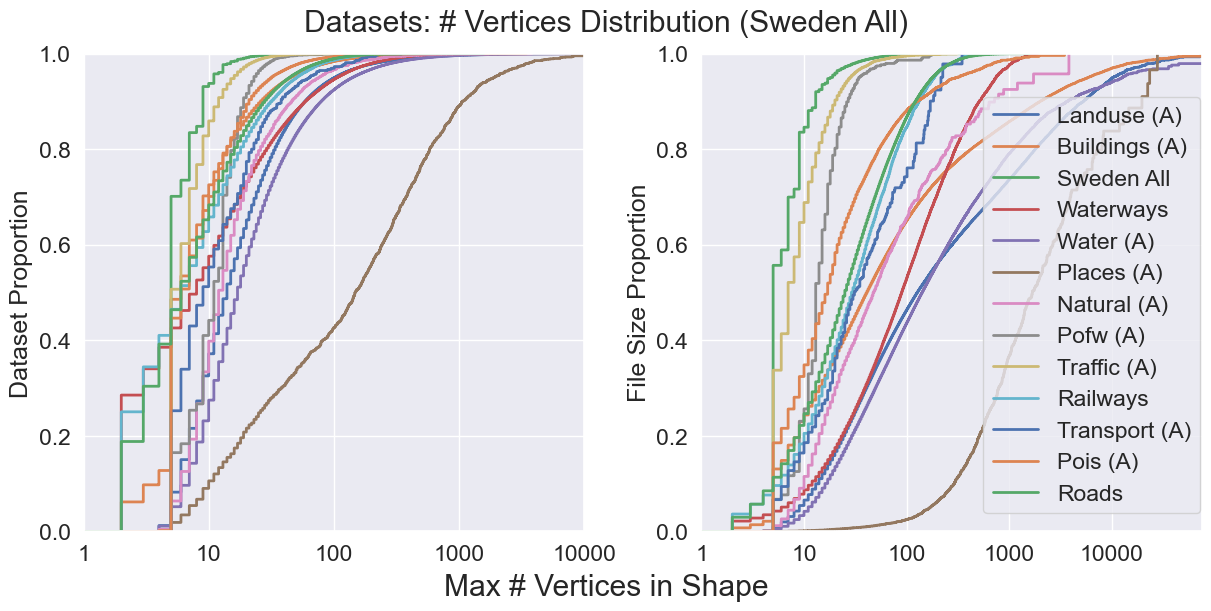

In [11]:
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
sns.set(font_scale=1.5)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), constrained_layout=True)
axes = axes.flatten()
fig.supxlabel("Max # Vertices in Shape")
fig.suptitle("Datasets: # Vertices Distribution") # (Sweden All)


for f, v in all_vertex_cnts:
    if len(v) == 0:
        continue
    sns.ecdfplot(v, ax=axes[0], linewidth = 2)
    #sns.displot(v, kind="kde")

legend = fig.legend(legends, loc='center right')
axes[0].set_xscale('log')
axes[0].set_xlim(1, 10000)
formatter = ScalarFormatter()
formatter.set_scientific(False) 
axes[0].xaxis.set_major_formatter(formatter)
#axes[0].set_xlabel("Max # Verticies in Shape")
axes[0].set_ylabel("Dataset Proportion")

# Weighted
for f, counts in all_vertex_cnts:
    if len(counts) == 0:
        continue
    weighted = [s for s in counts for _ in range(s)]
    sns.ecdfplot(weighted, ax=axes[1], linewidth = 2)
axes[1].set_xscale('log')
axes[1].set_xlim(1, 75000)
axes[1].xaxis.set_major_formatter(formatter)
axes[1].set_ylabel("File Size Proportion")

#fig.tight_layout()
plt.show()